##  FCI Simulated Images and  Image Denoising 
#### Code written by Doroteya Stoyanova

## 1. What is our data ?
Our dataset consists of simulated FCI (Field-Cycling Imaging) scans, where each scan is represented as a 2D multichannel image with dimensions HxWxExM (height, width, evolution time (5), and magnetic field (3)). Essentially, each image can also be viewed as a 3D volume. However, in our experimentation, we merge the magnetic field and evolution time dimensions, resulting in a total of 15 channels.

There are two approaches to interpret the data:

    1) Flat Multichannel Approach (90x90x15): Here, the evolution time and magnetic field dimensions are merged into a single dimension, resulting in a flat multichannel image where each "channel" represents a unique combination of evolution time and magnetic field strength. This approach simplifies the data structure but potentially obscures interactions between the evolution time and magnetic field dimensions.
    2) Separate Dimensions Approach (90x90x5x3): This approach maintains the separation between evolution time and magnetic field dimensions, treating the dataset as a 4D volume. This preserves the distinct effects of evolution time and magnetic field strength, potentially allowing for more nuanced analysis of their interactions.
   

## How is our evaluation structured: 
1) We are first exploring the dataset and its capacibilities,such as what the grayscale version allows for and what the coloured version allows for, also what is the spatial dimension, we also explore the Gaussian noise and Rician noise.Using the given simulated data , we created our own validation and test sets which allow for thorough algorithmic estimation: 5 levels of Rician and 5 levels of Gaussian noise tests on the simulated data.
2) Then ,we first employ the first approach as its easier 90x90x15 for the traditional methods: for now we are testing 3 traditional methods : NLM , BM3D and TGV , neiher of them actually needs a clean counterpart
3) Then, we try self-supervised and blind denoising methods: Patch2Self and Noise2Self( potentially will apply another one) and compare results
4) Test Visually how all those methods perform 
5) Test also using MEtrics 
6) Ask for the feedback of a medical radiographer staff member

In [5]:

from os.path import dirname, join as pjoin

import scipy.io 
import matplotlib.pyplot as plt
import numpy as np


In [78]:

mat = scipy.io.loadmat('/Users/dolorious/Downloads/simulation-1/GroundTruth.mat')
image_data = mat['data']

image_data.shape
# Look at the dictionary items
mat.items()
mat["data"] 

array([[[[0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972]],

        [[0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972]],

        [[0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972]],

        ...,

        [[0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972],
         [0.49768972, 0.49768972, 0.49768972]],

        [[0.49768972, 0.49768972, 0.49

# Ground truth image visualise : 



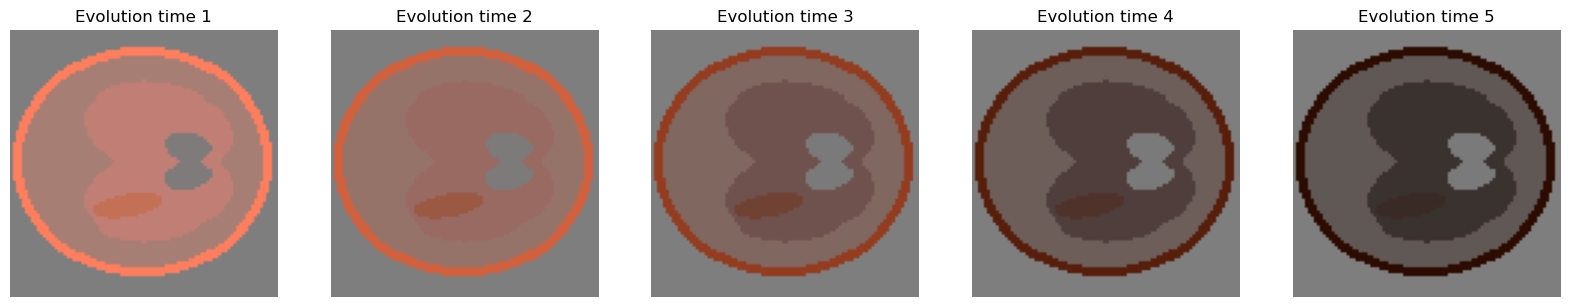

In [28]:
plt.figure(figsize=(20, 4))  # Adjust the figure size as needed to fit all images horizontally.

conditions = image_data.shape[2]  # Assuming this represents different conditions.

for i in range(conditions):
   
    rgb_image = image_data[:, :, i, :]  # This is based on your array's shape; adjust if needed.

    # Create a subplot for each condition's image.
    plt.subplot(1, conditions, i+1)  # 1 row, N columns, ith subplot
    plt.imshow(rgb_image)
    plt.title(f'Evolution time {i+1}')
    plt.axis('off')  # Optionally turn off the axis for a cleaner look.

plt.show()


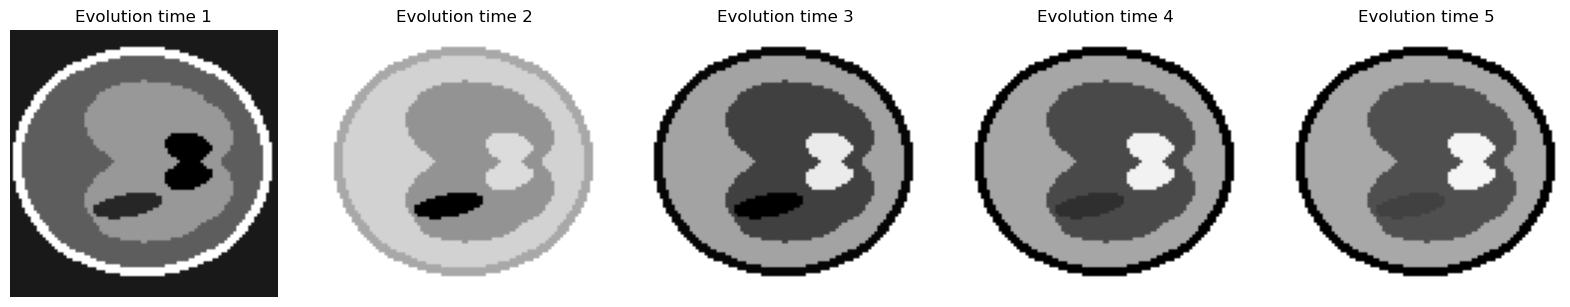

In [29]:
from skimage.color import rgb2gray

plt.figure(figsize=(20, 4))  # Adjust the figure size as needed to fit all images horizontally.

conditions = image_data.shape[2]  # Assuming this represents different conditions.

for i in range(conditions):
    # Extract the RGB image for the ith condition.
    rgb_image = image_data[:, :, i, :] 

    # Convert RGB image to grayscale.
    grayscale_image = rgb2gray(rgb_image)

    
    plt.subplot(1, conditions, i+1) 
    plt.imshow(grayscale_image, cmap='gray')  # Display grayscale image
    plt.title(f'Evolution time {i+1}')
    plt.axis('off')  

plt.show()

In [ ]:
# Now , let us look at the noisy data in general ! 

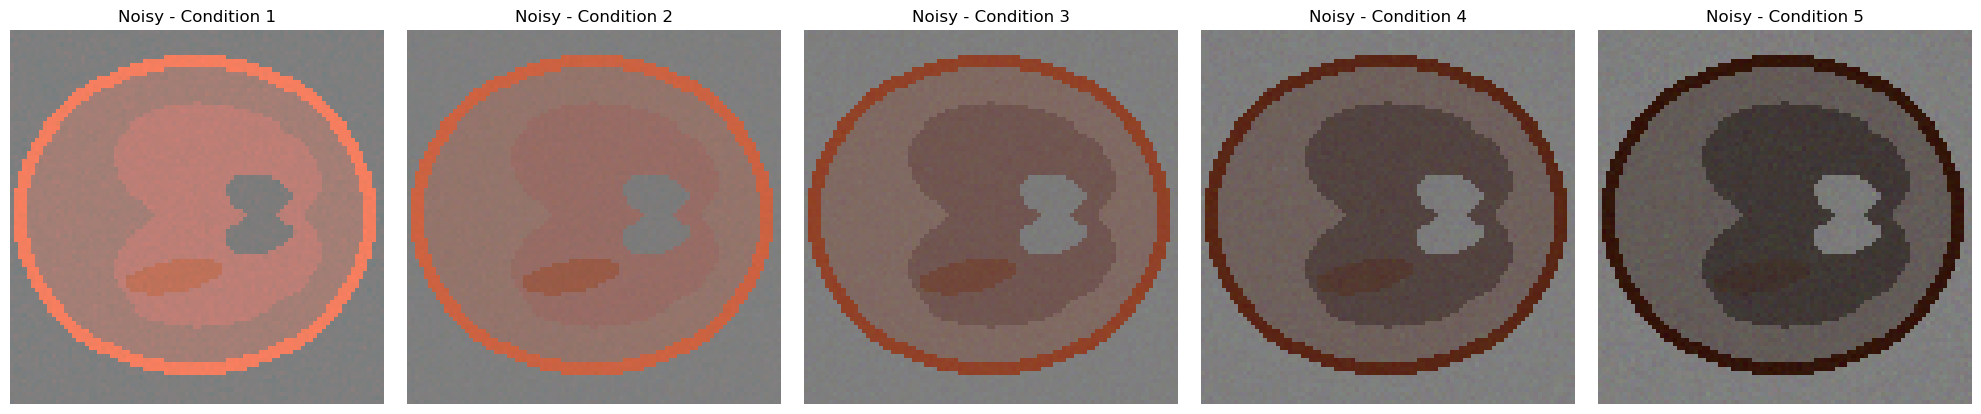

In [40]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Load the MAT file
mat = scipy.io.loadmat('/Users/dolorious/Downloads/simulation-1/GroundTruth_noise.mat')

# Extract noisy image data
noisy_image_data = mat['data_n']

plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.

for i in range(conditions):
    # Extract the noisy image for the ith condition.
    noisy_image = noisy_image_data[:, :, i]  

    # Ensure the values are in the range [0, 1]
    noisy_image = np.clip(noisy_image, 0, 1)

    # Plot the noisy image.
    plt.subplot(2, conditions, i+1)  # 2 rows, N columns, ith subplot
    plt.imshow(noisy_image, cmap='gray')  # Display noisy image in grayscale
    plt.title(f'Noisy - Condition {i+1}')
    plt.axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()



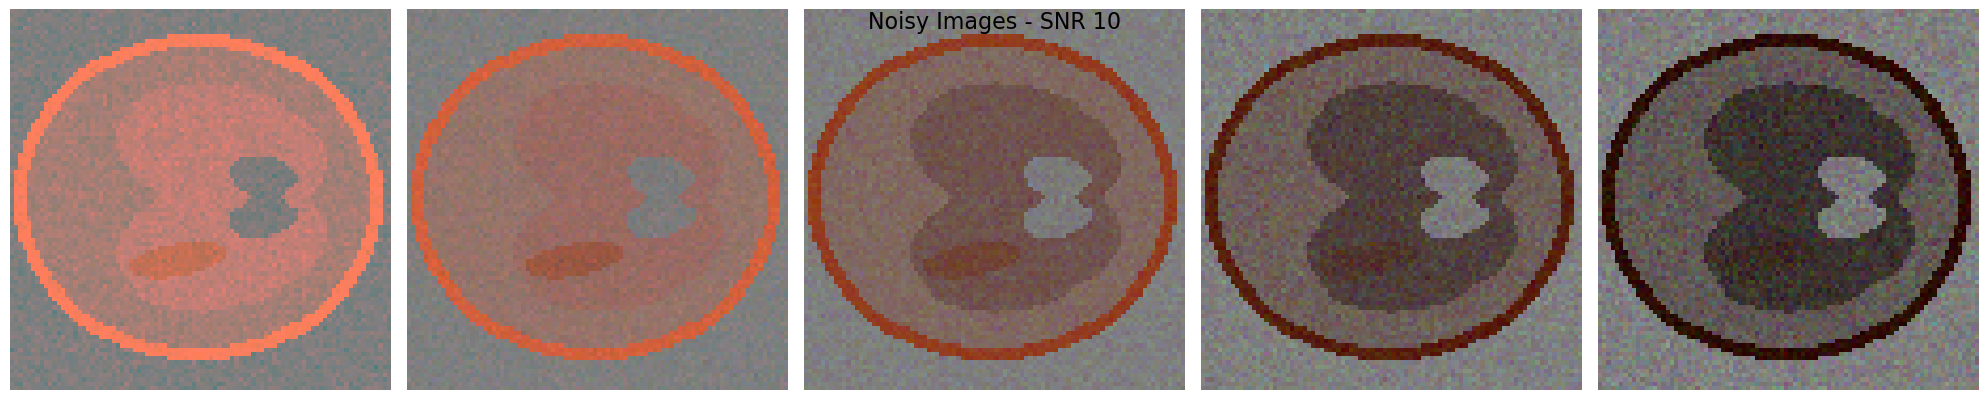

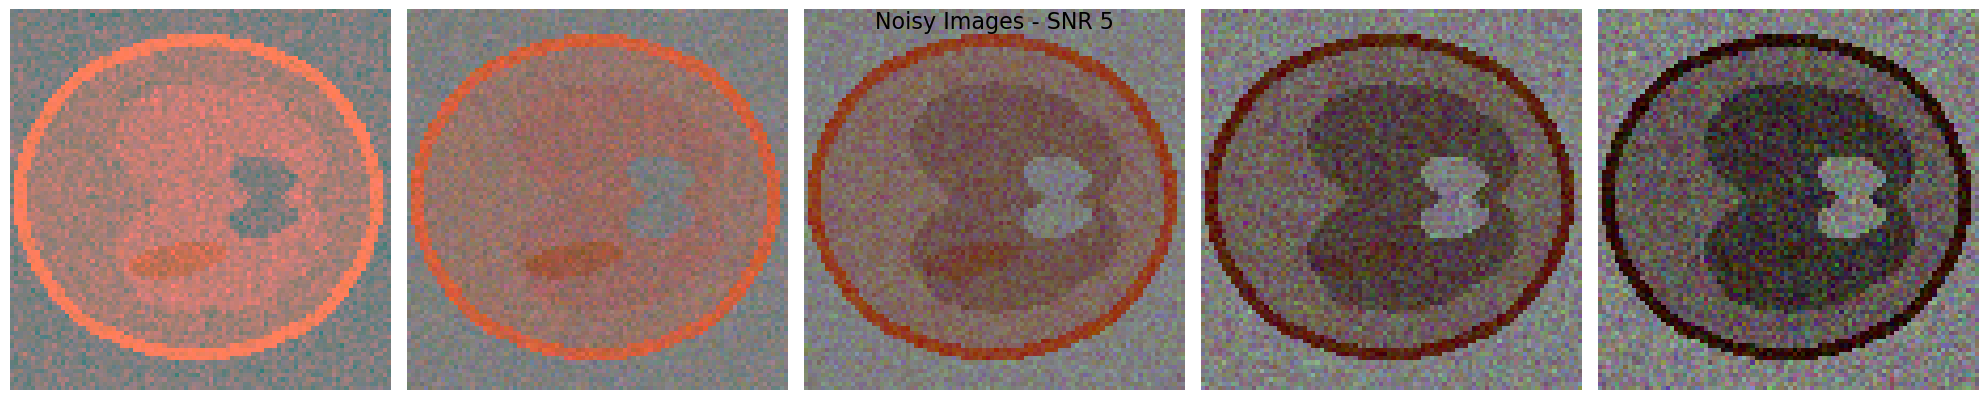

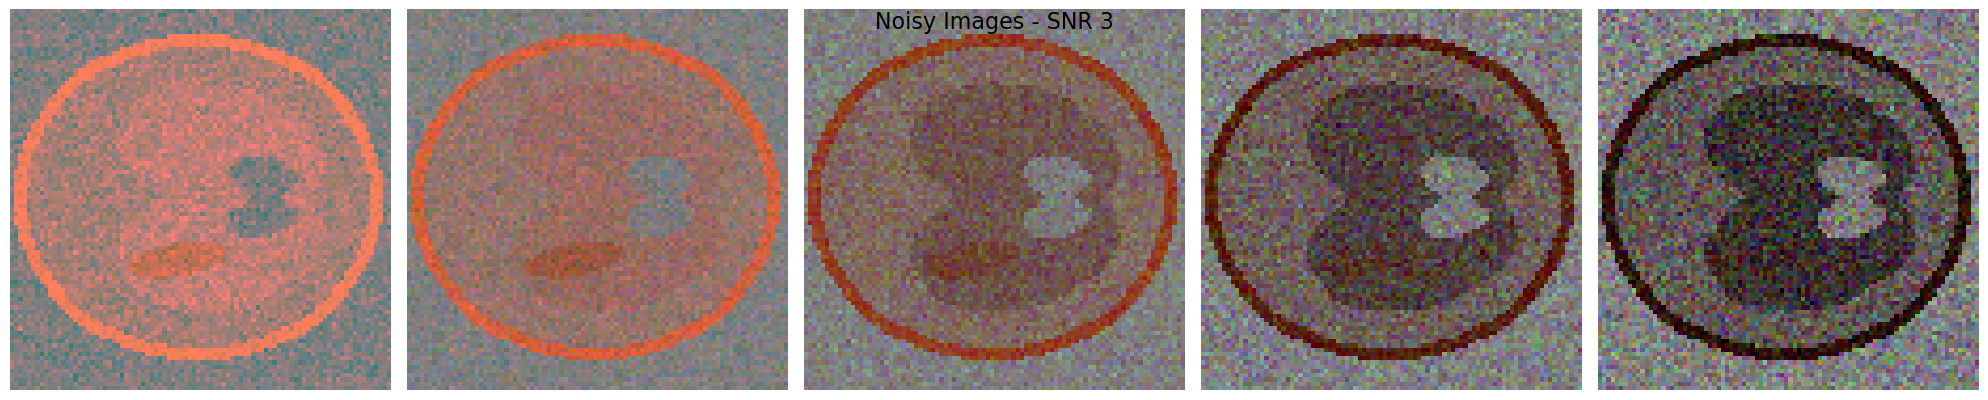

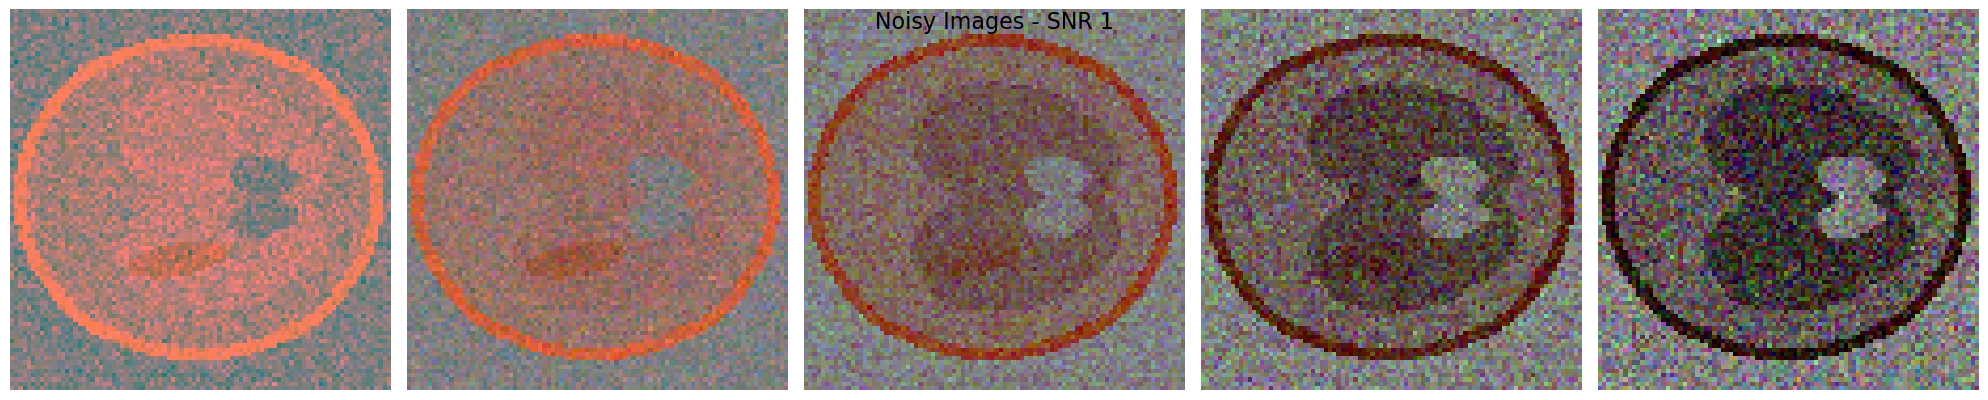

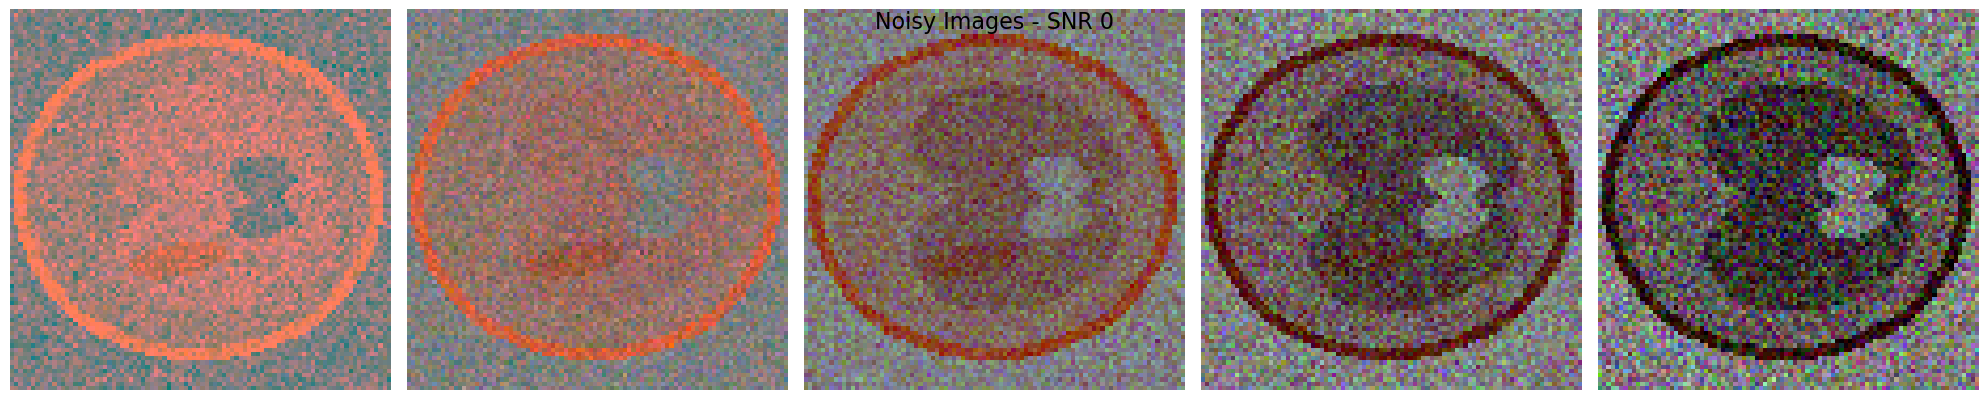

In [75]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from skimage.color import rgb2gray


# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_gaussian']

    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.

    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j]  

        # Ensure the values are in the range [0, 1]
        noisy_image = np.clip(noisy_image, 0, 1)

        # Plot the noisy image.
        plt.subplot(2, conditions, j+1)  # 2 rows, N columns, jth subplot
        plt.imshow(noisy_image, cmap='gray')  # Display noisy image in grayscale
        plt.axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.suptitle(f'Noisy Images - SNR {snr}', fontsize=16)
    plt.show()



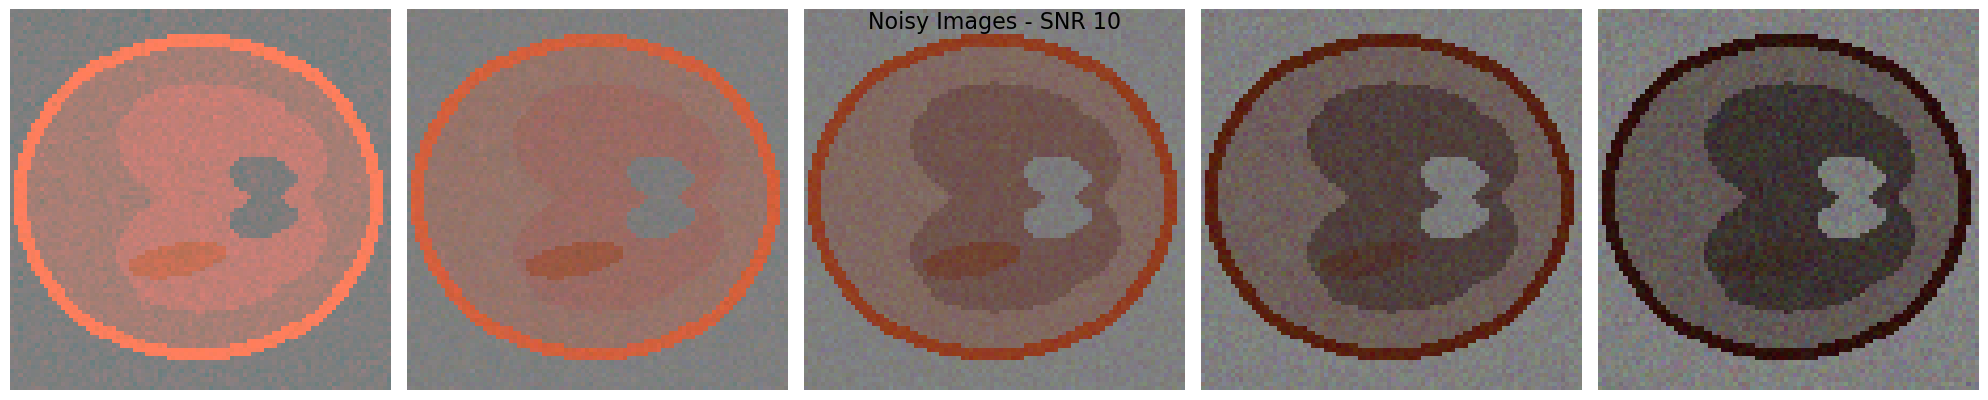

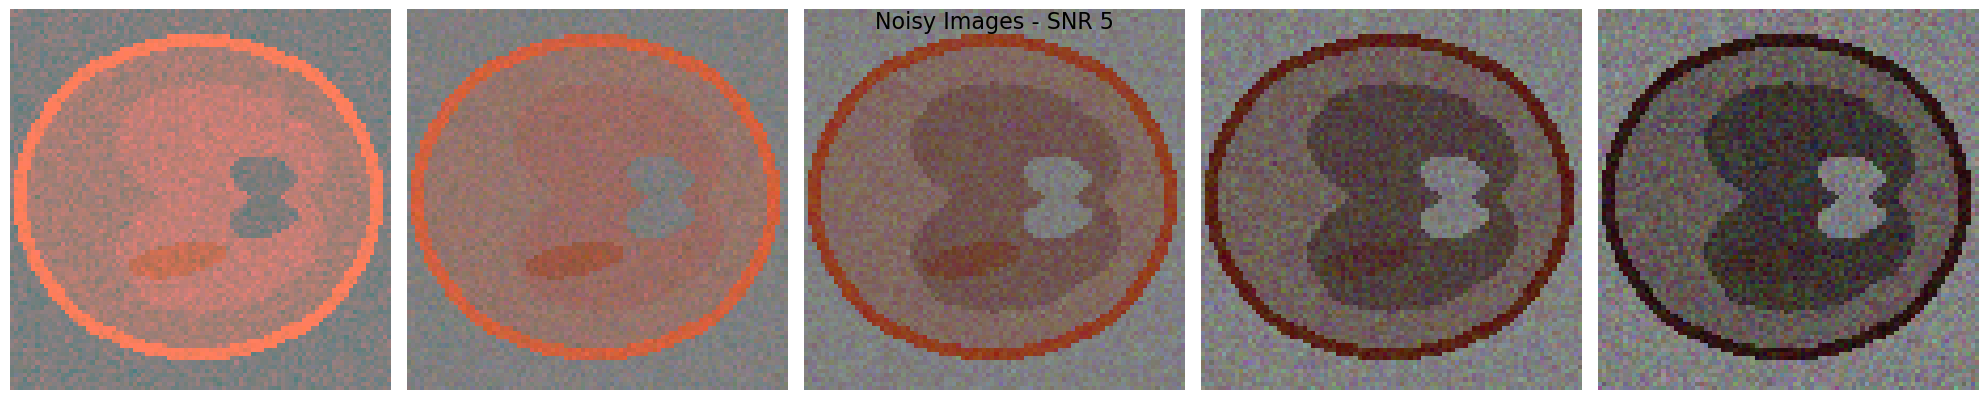

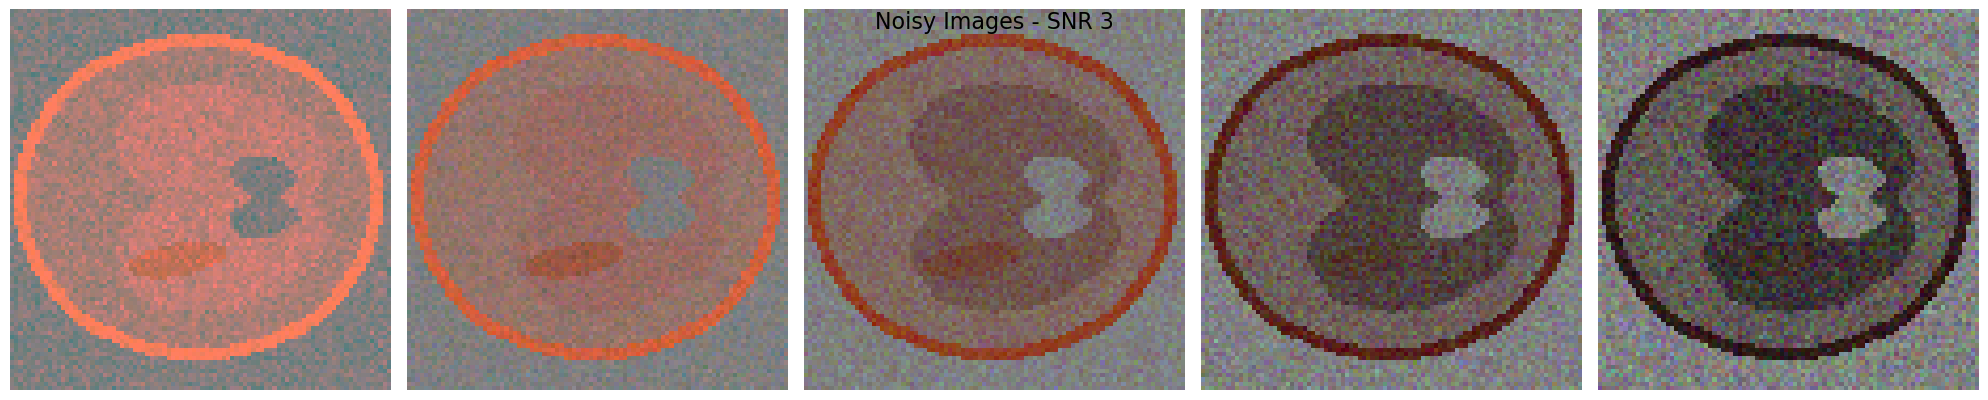

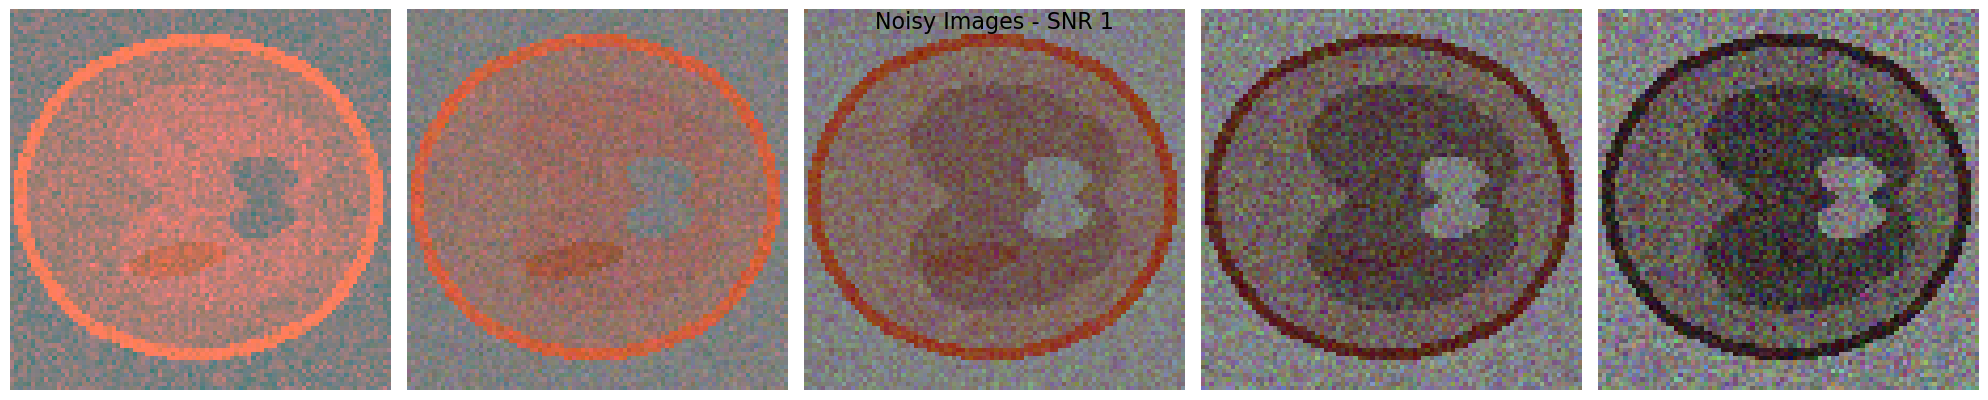

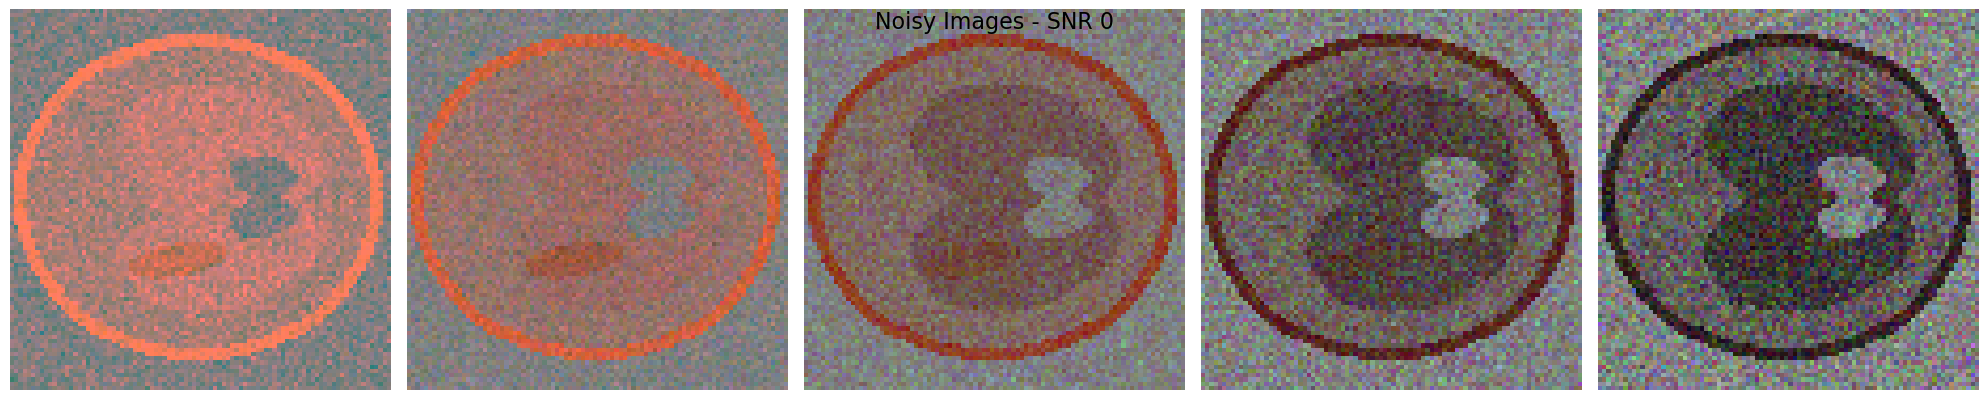

In [76]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_rician_SNR{snr}.mat')

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_rician']

    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.

    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j]  

        # Ensure the values are in the range [0, 1]
        noisy_image = np.clip(noisy_image, 0, 1)

        # Plot the noisy image.
        plt.subplot(2, conditions, j+1)  # 2 rows, N columns, jth subplot
        plt.imshow(noisy_image, cmap='gray')  # Display noisy image in grayscale
        plt.axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.suptitle(f'Noisy Images - SNR {snr}', fontsize=16)
    plt.show()


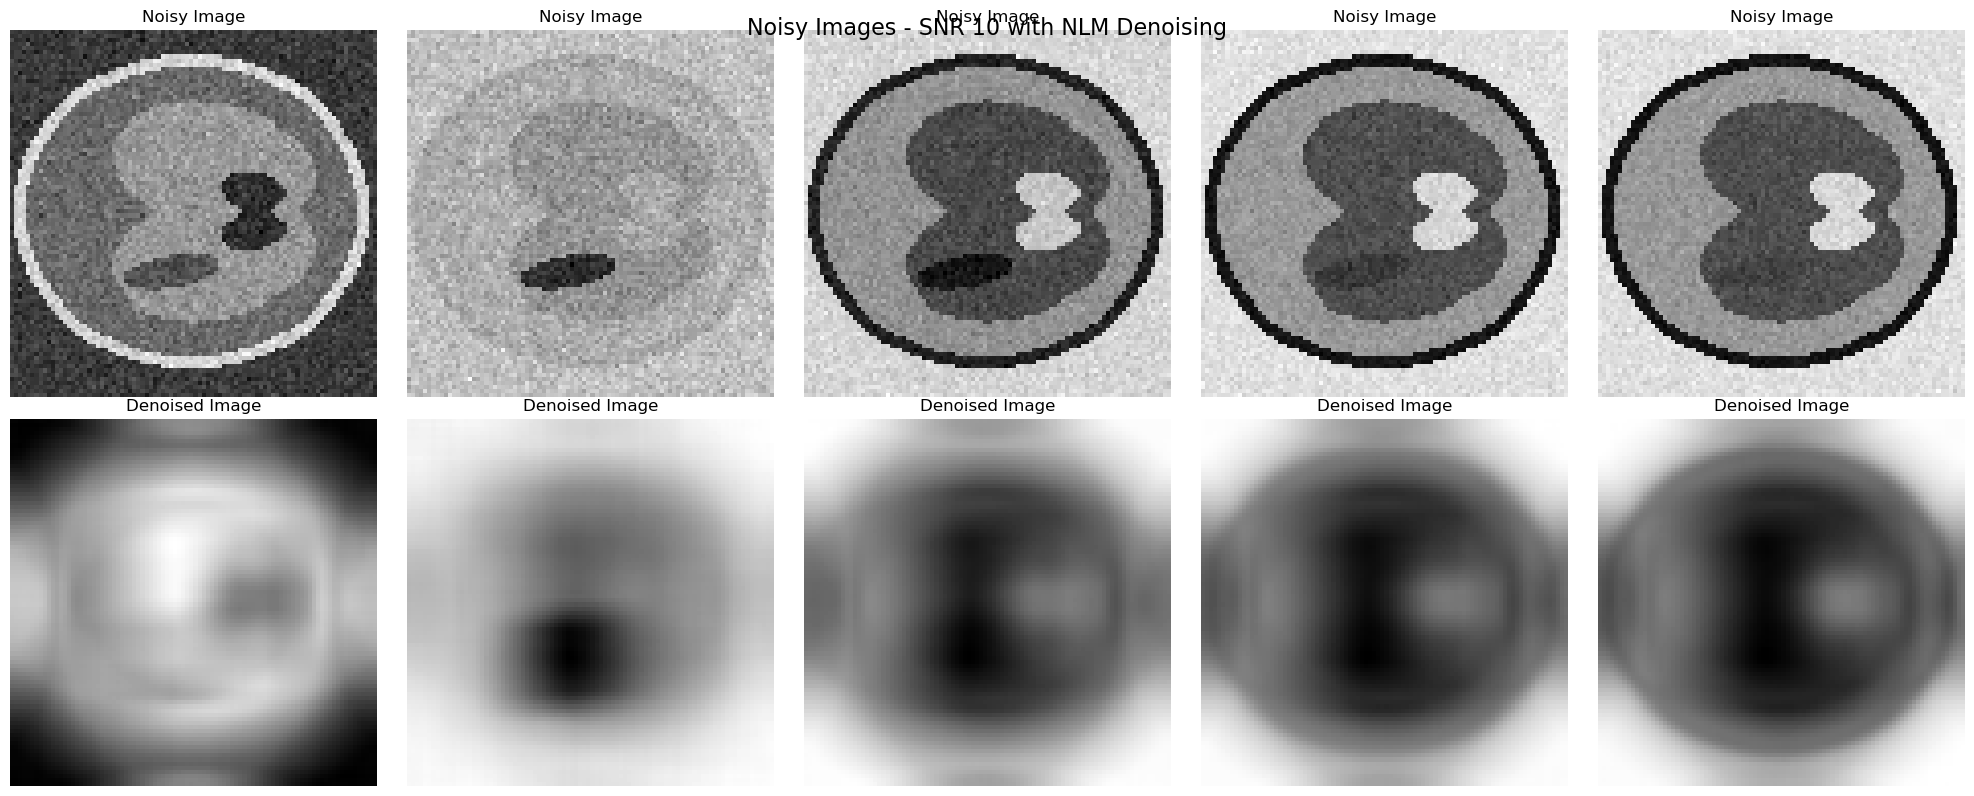

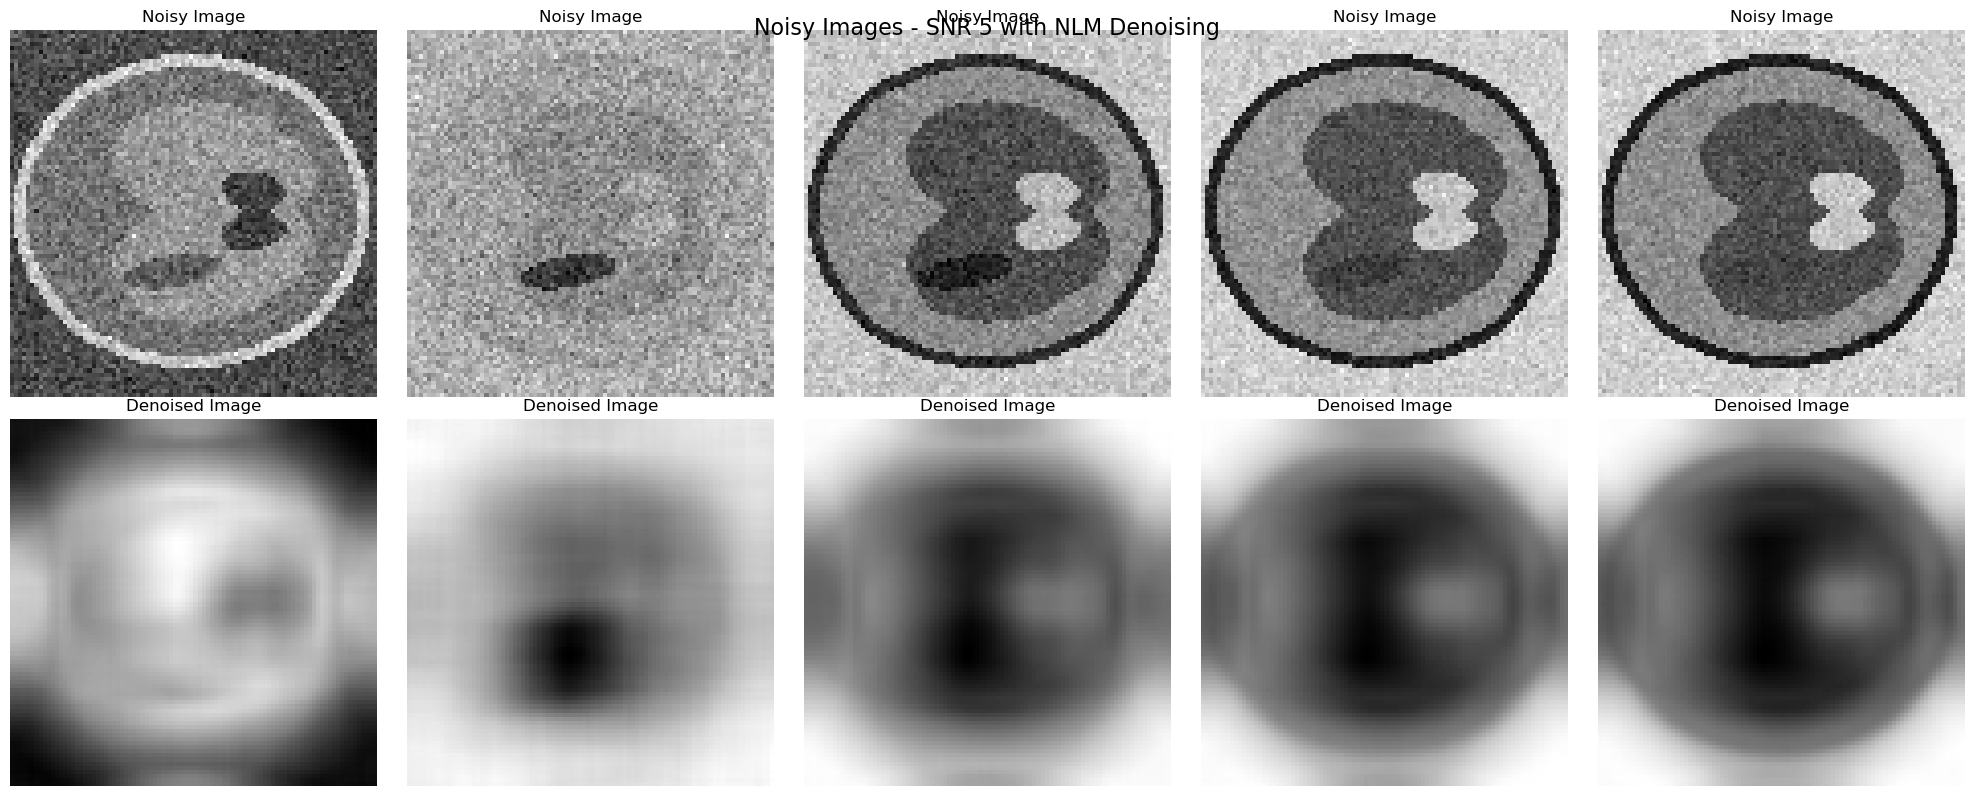

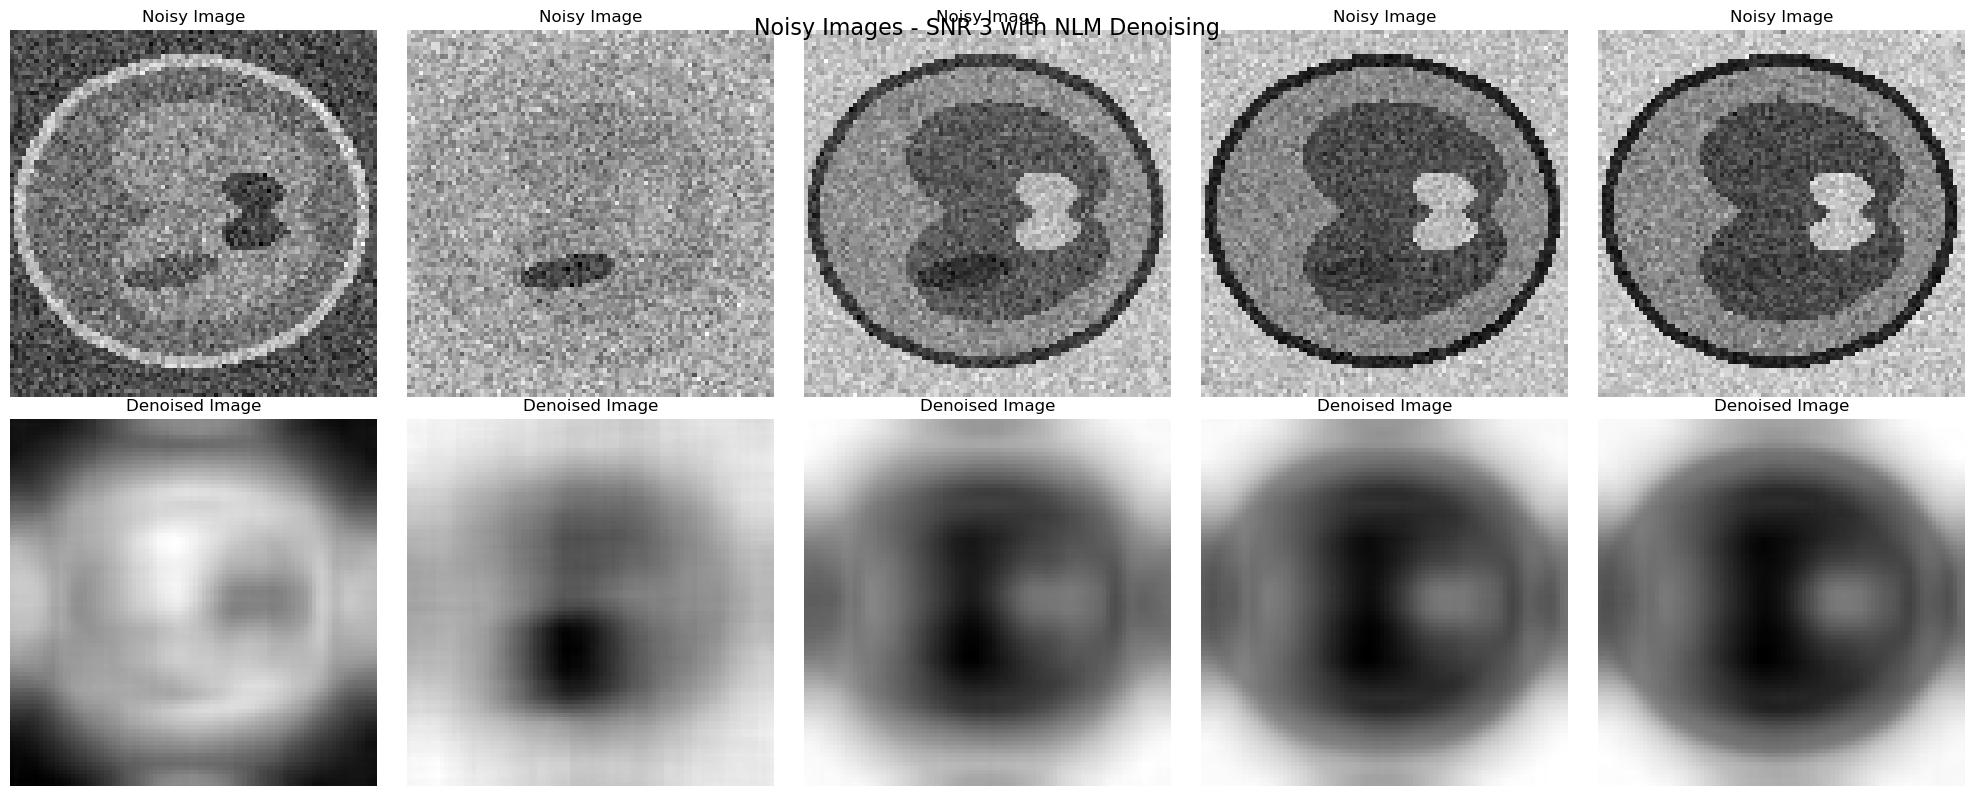

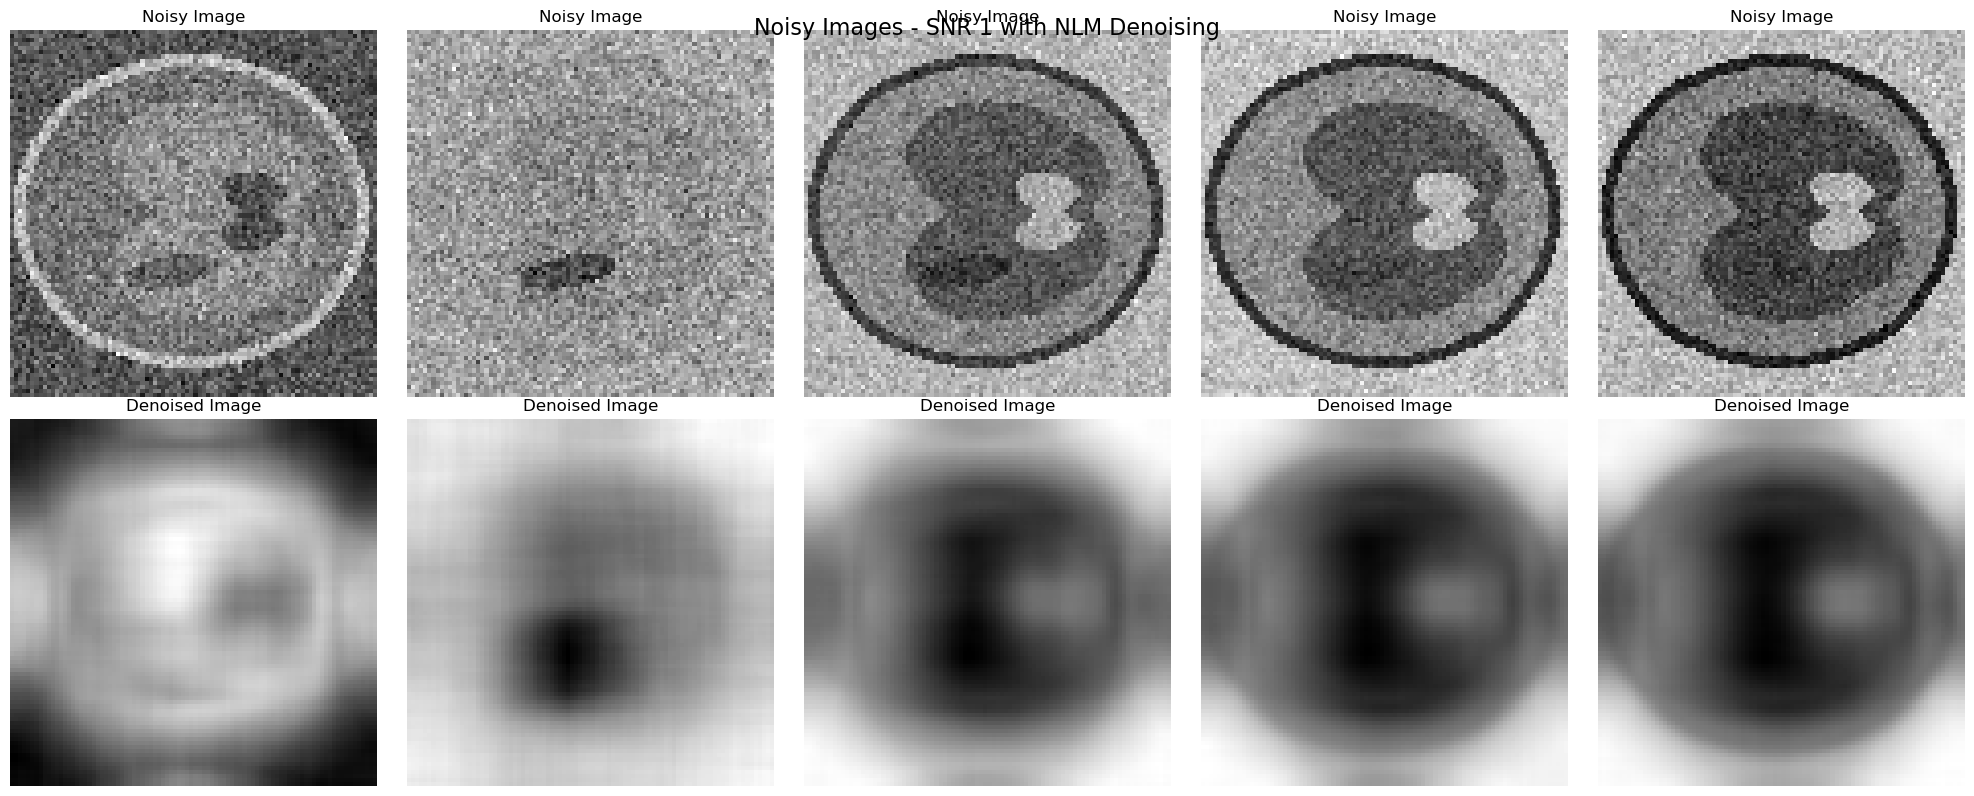

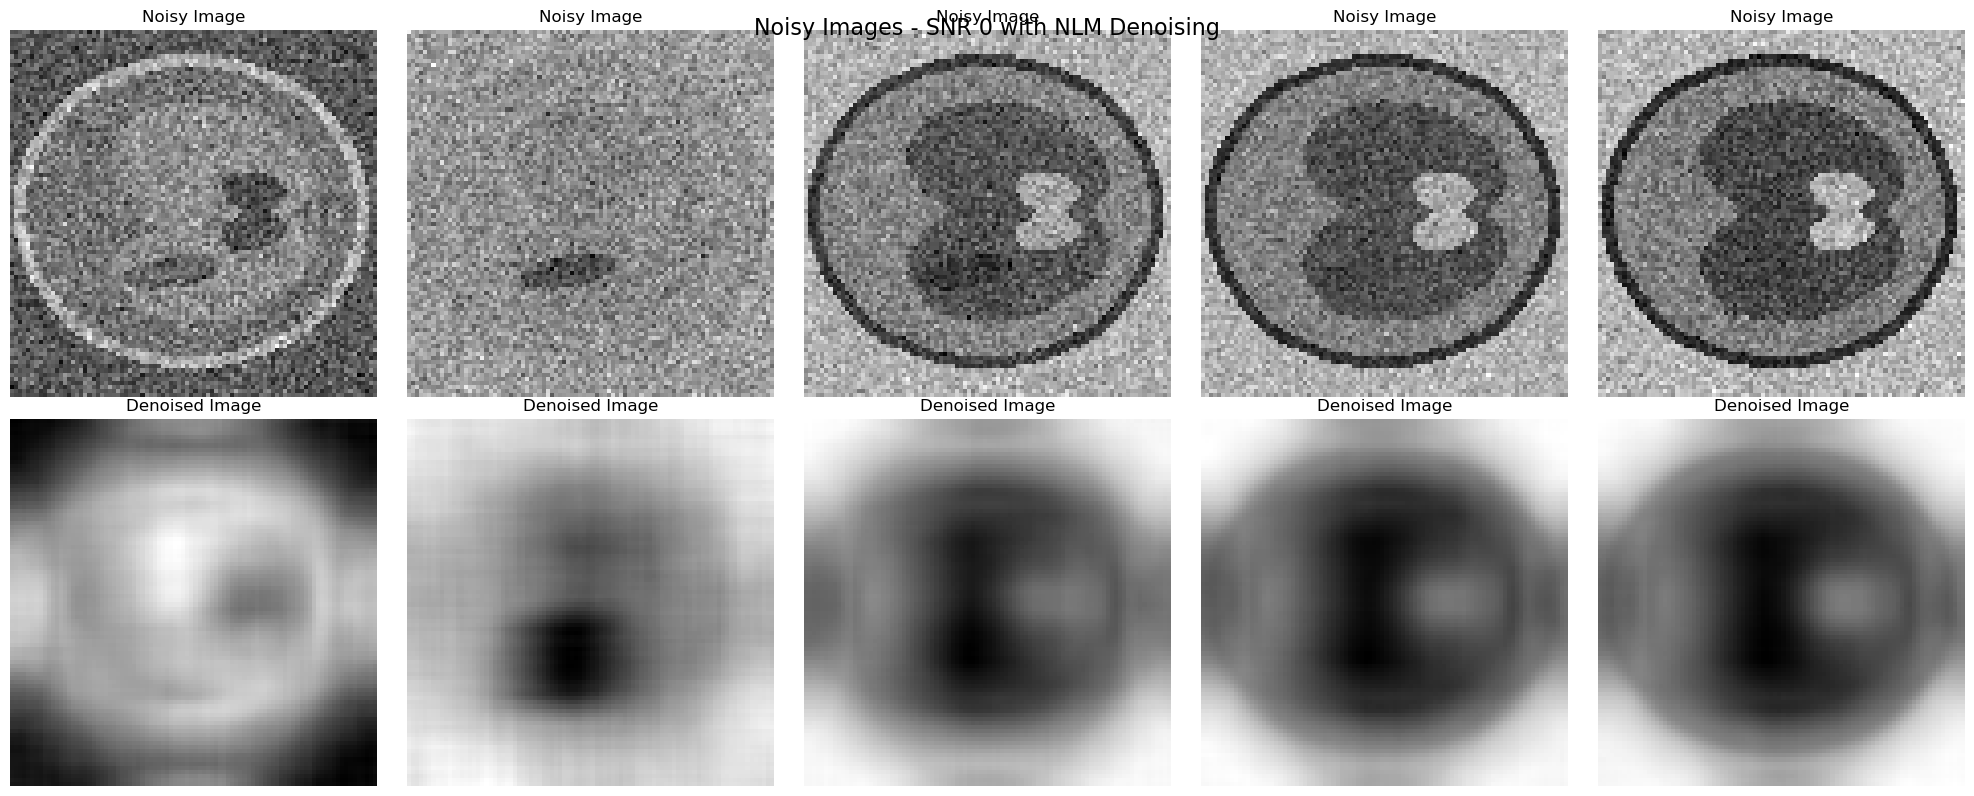

In [77]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from skimage import restoration

# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_rician_SNR{snr}.mat')

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_rician']

    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.

    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()

        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
            # If the image is already grayscale or doesn't meet the RGB shape assumption
            noisy_image_gray = noisy_image

        # Apply NLM denoising
        denoised_image = restoration.denoise_nl_means(noisy_image_gray, h=0.2, patch_size=20, patch_distance=11)

        # Plot the original noisy image
        plt.subplot(2, conditions, j + 1)  # 2 rows, N columns, jth subplot
        plt.imshow(noisy_image_gray, cmap='gray')  # Display noisy image in grayscale
        plt.title('Noisy Image')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(2, conditions, j + conditions + 1)  # 2 rows, N columns, (j+N)th subplot
        plt.imshow(denoised_image, cmap='gray')  # Display denoised image in grayscale
        plt.title('Denoised Image')
        plt.axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.suptitle(f'Noisy Images - SNR {snr} with NLM Denoising', fontsize=16)
    plt.show()



/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_42008/1099877960.py:25: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=True))
/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_42008/1099877960.py:35: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised_image = denoise_nl_means(noisy_image, h=1.15 * sigma_est, fast_mode=True,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


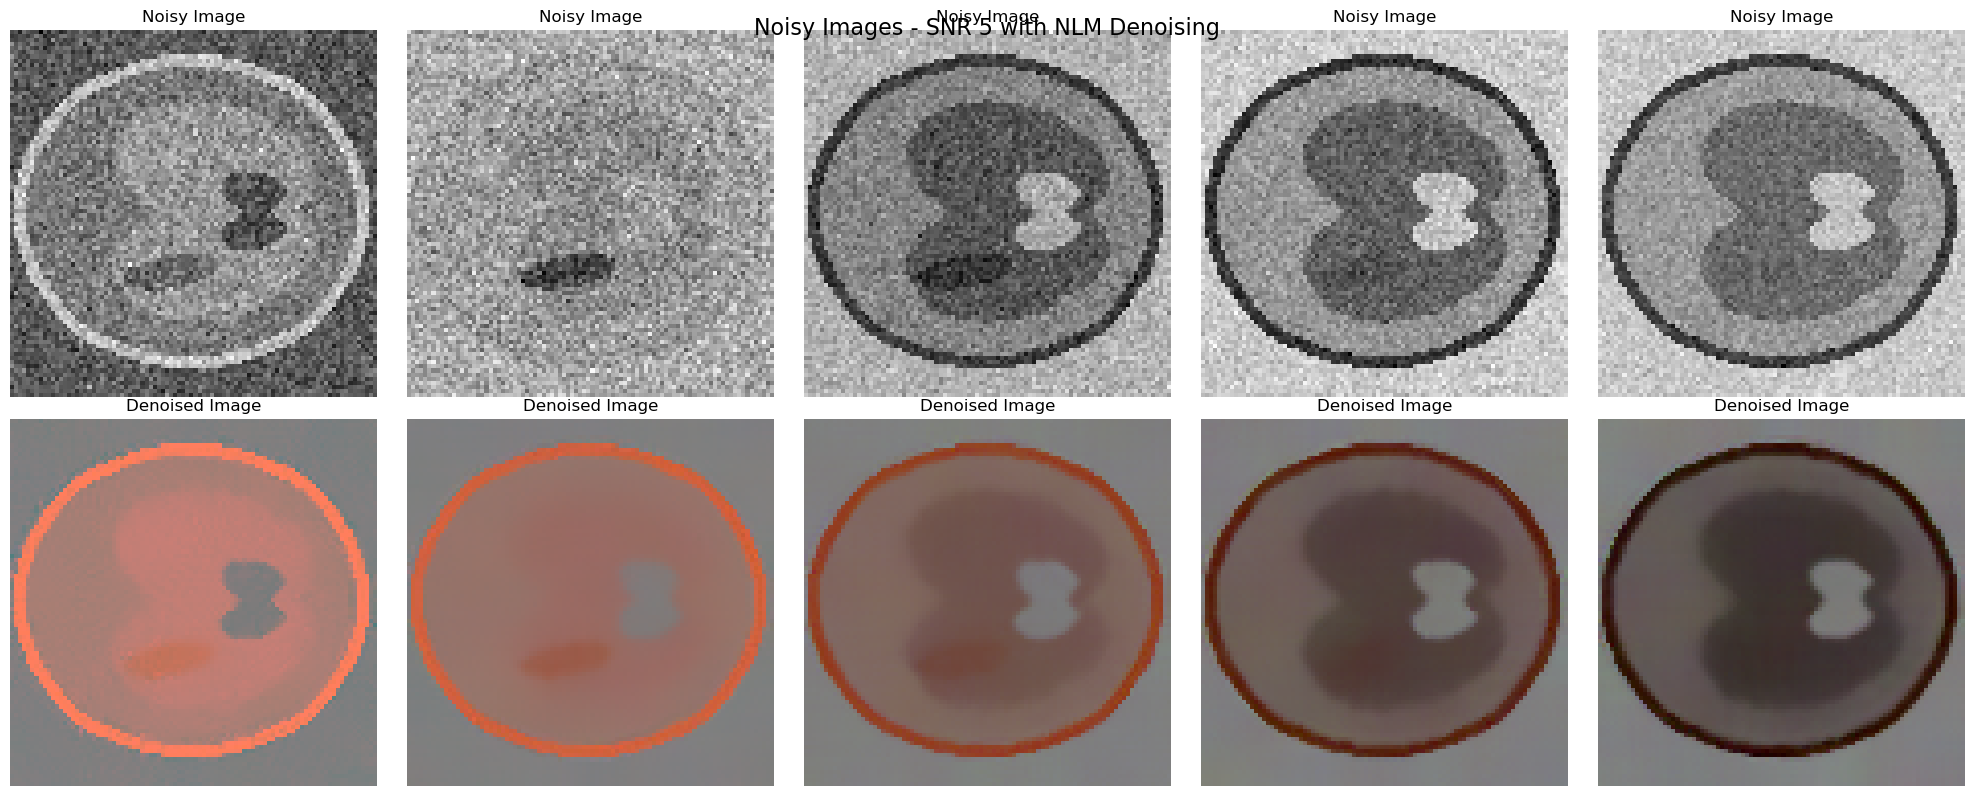

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


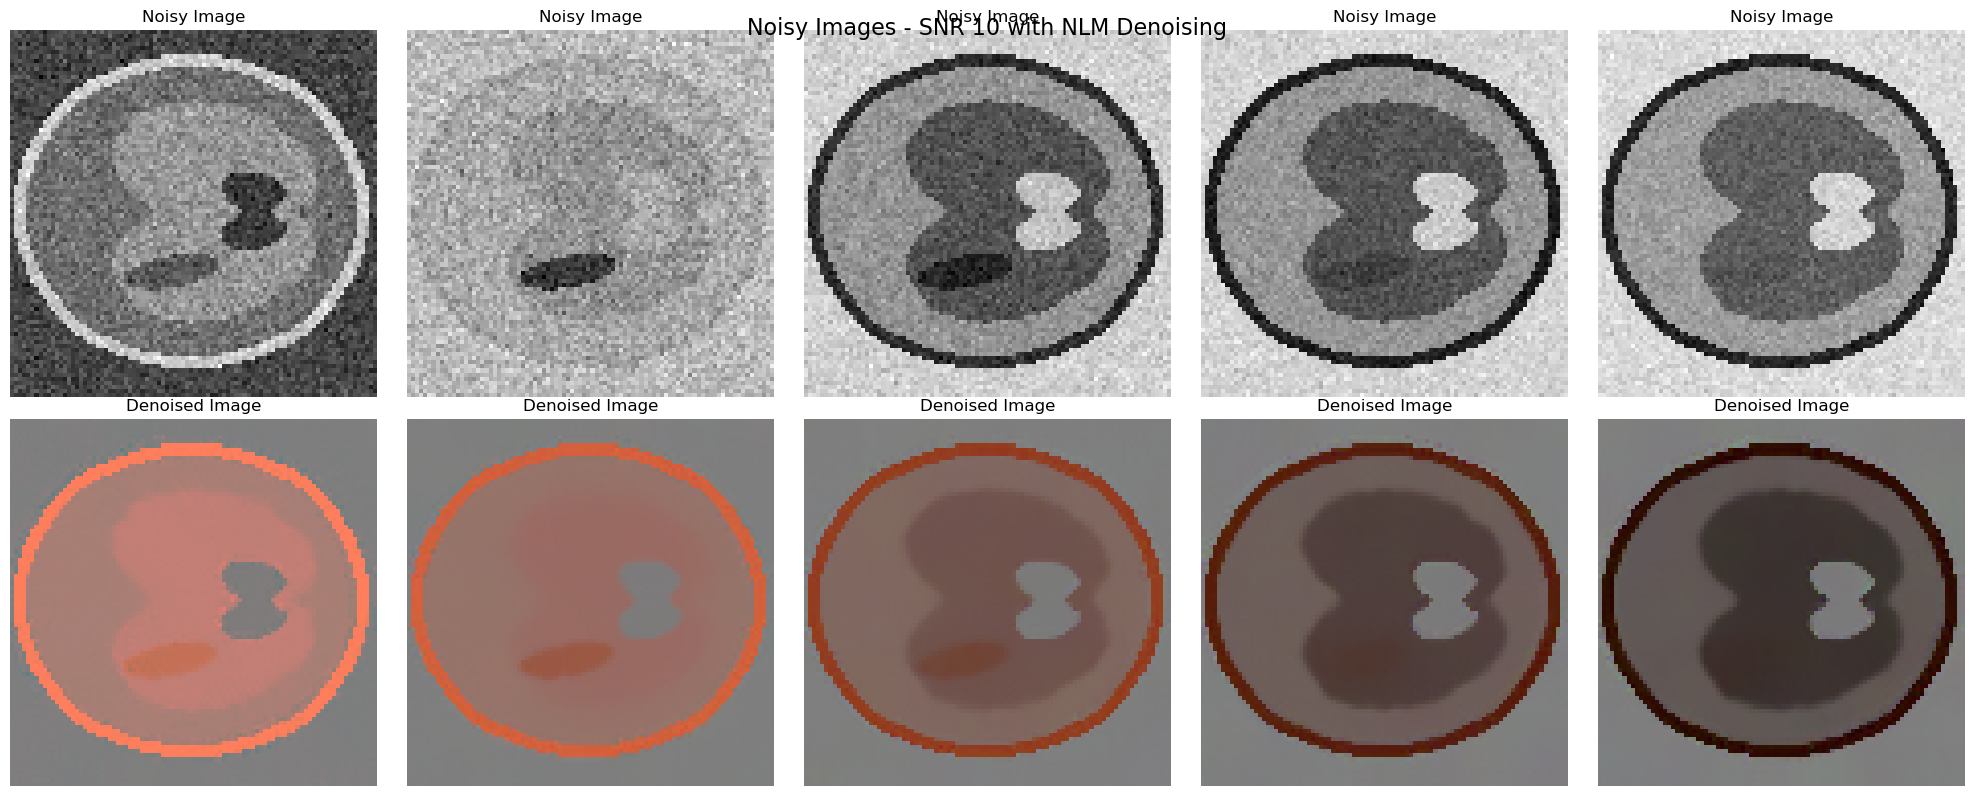

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


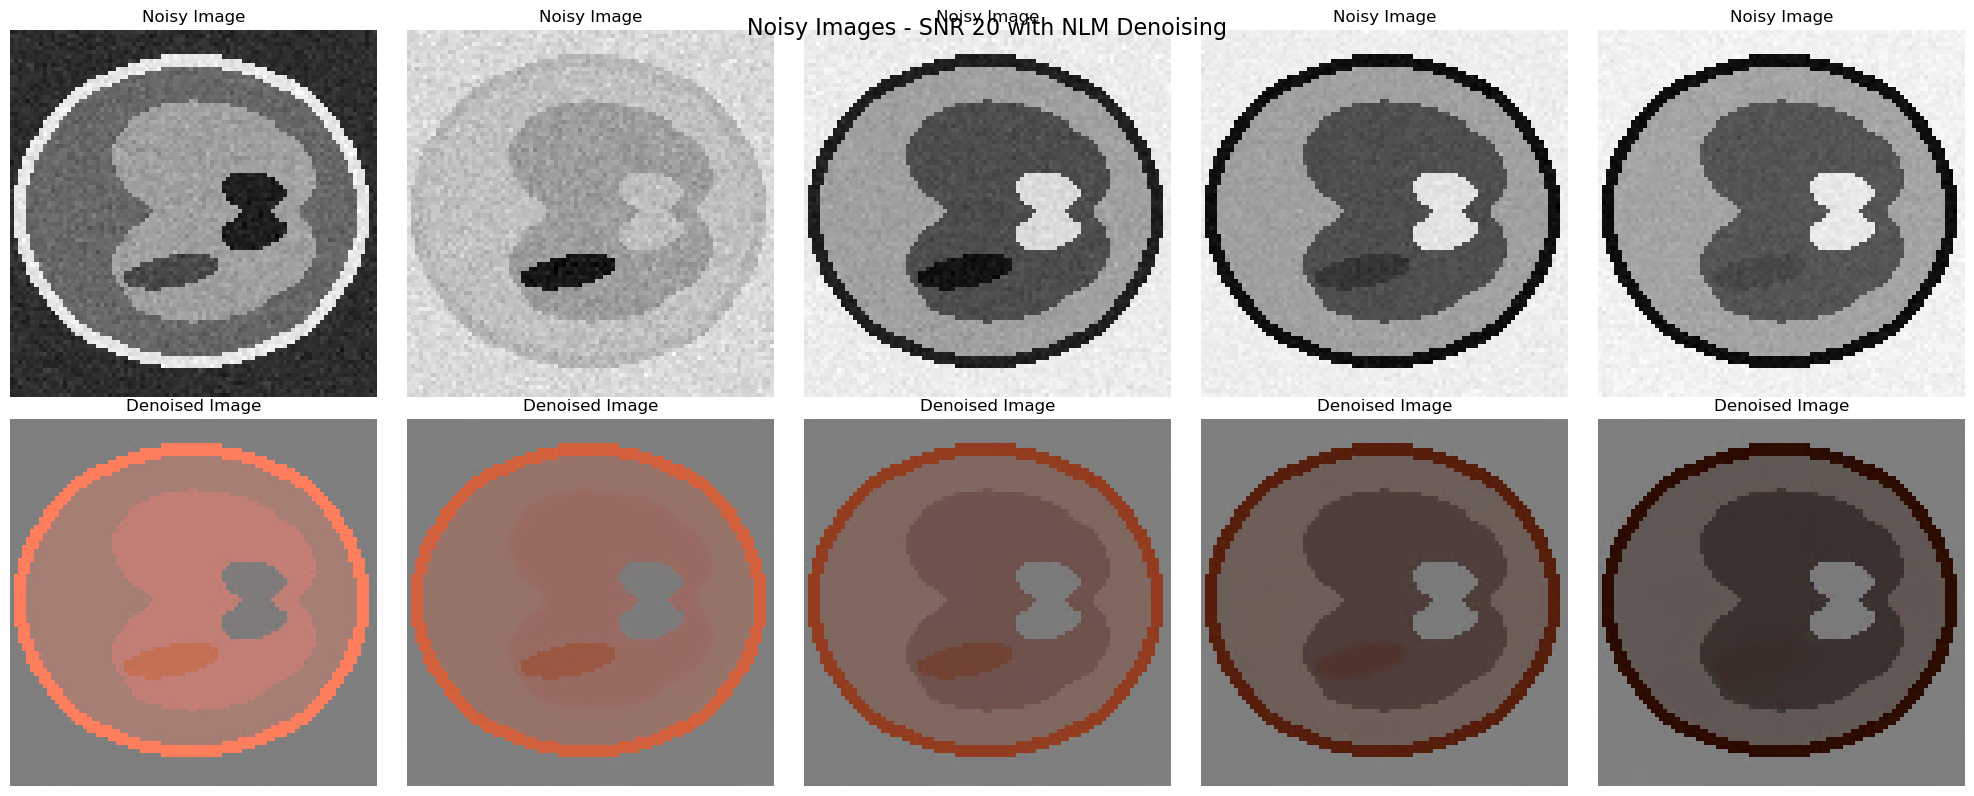

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


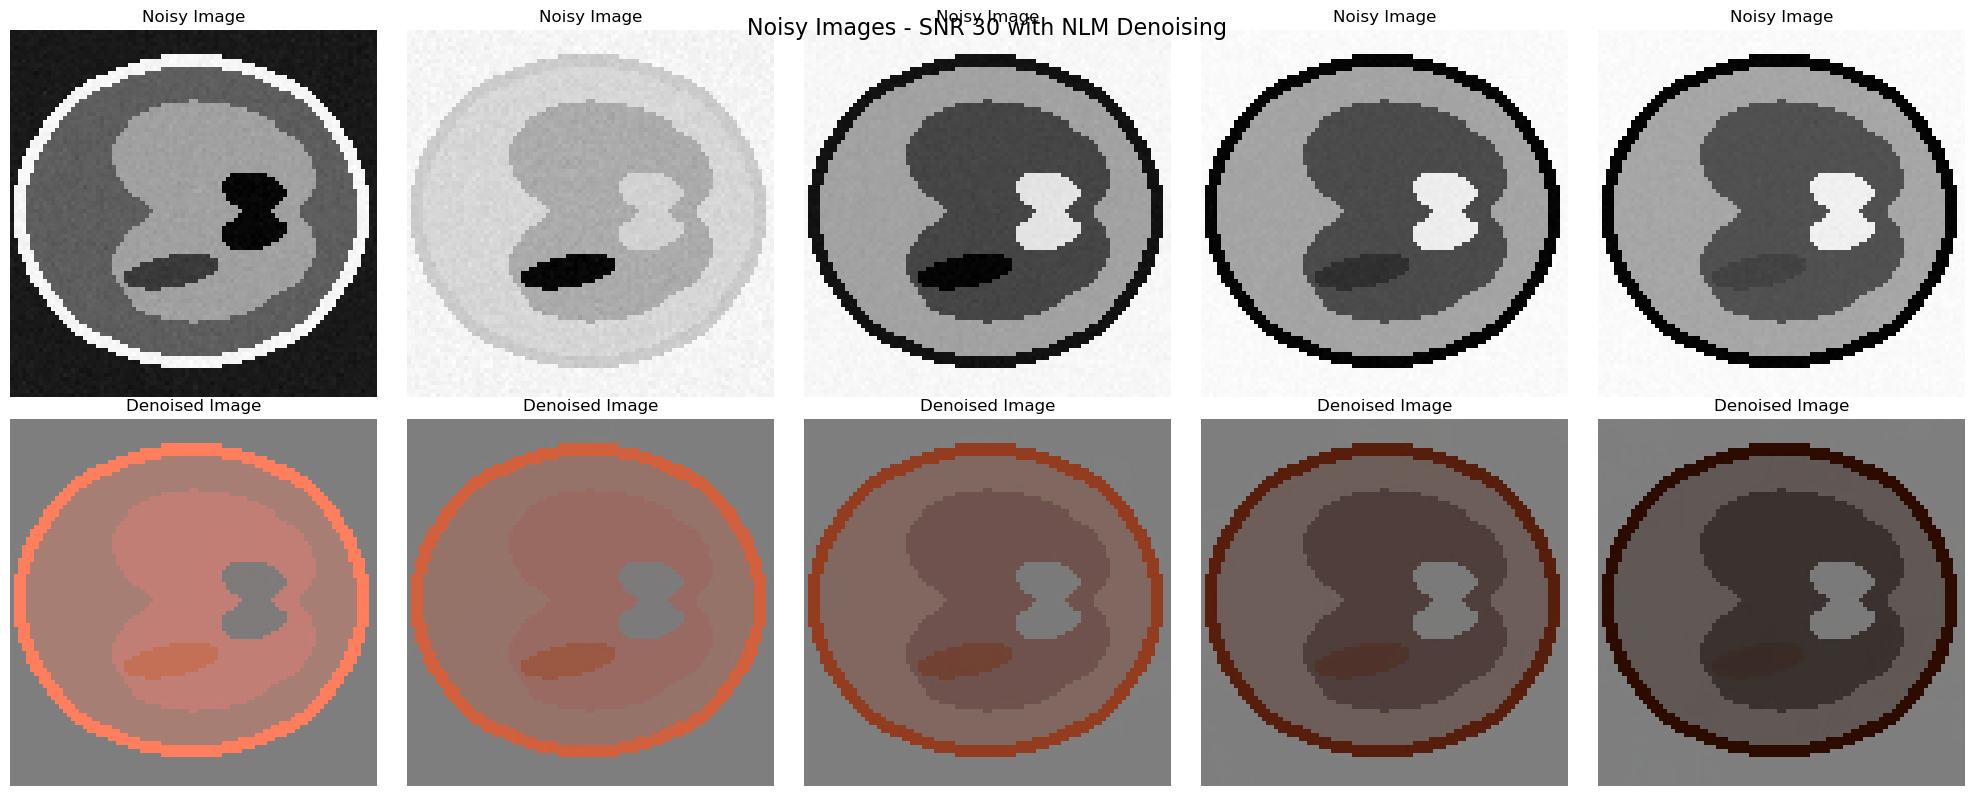

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


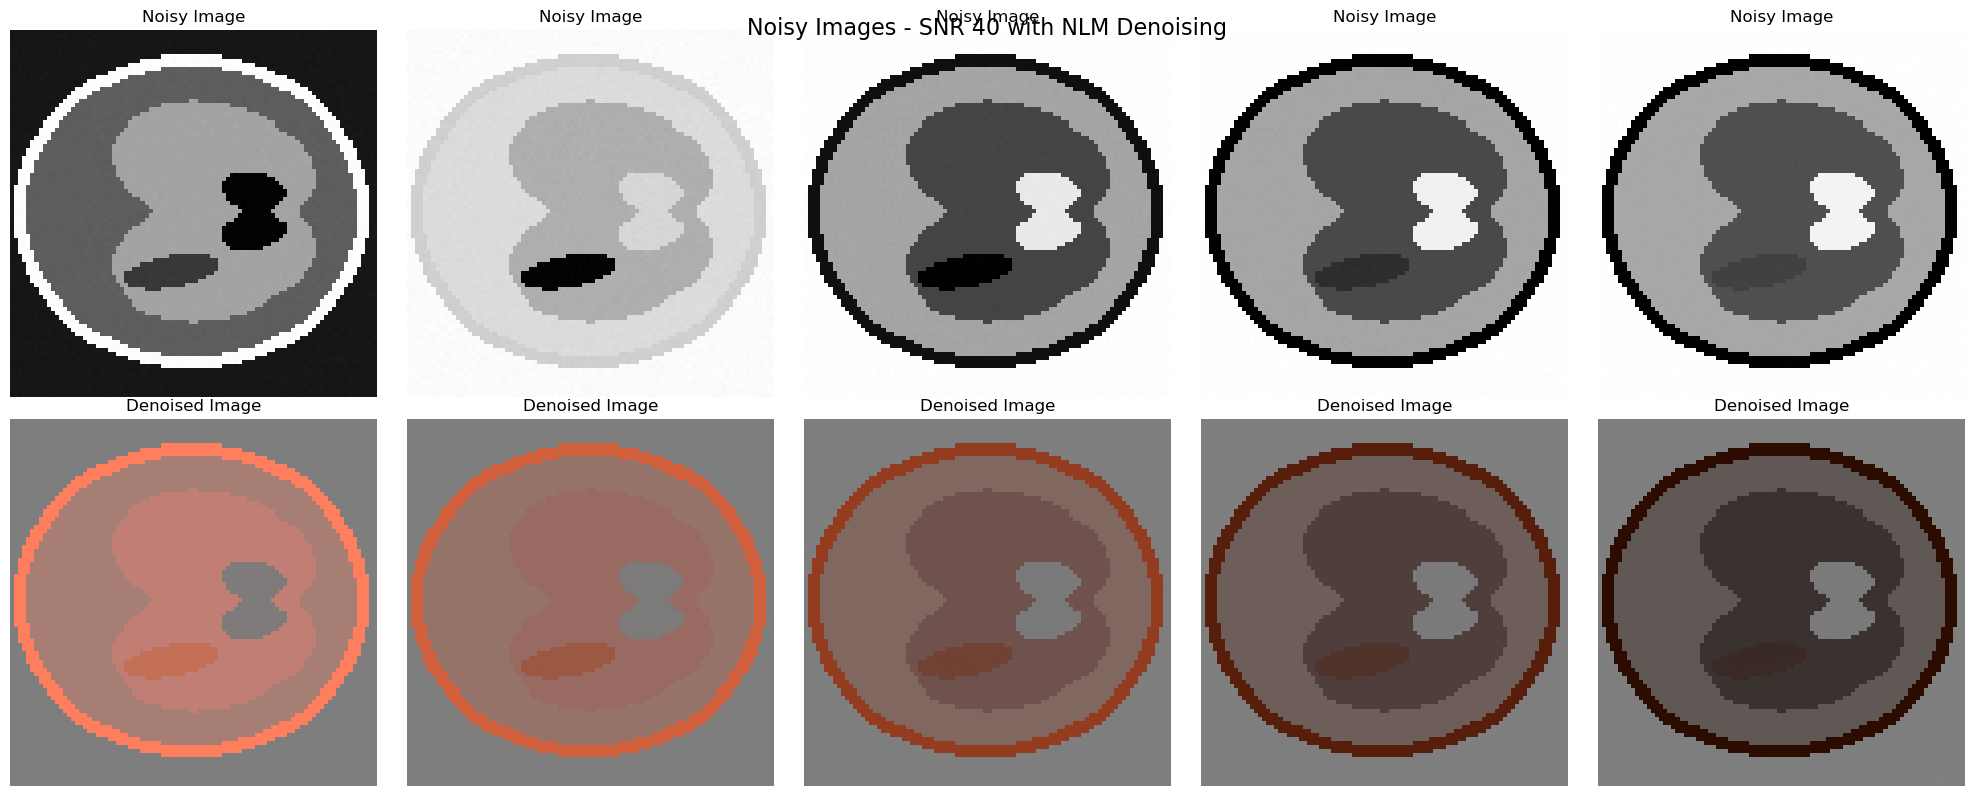

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


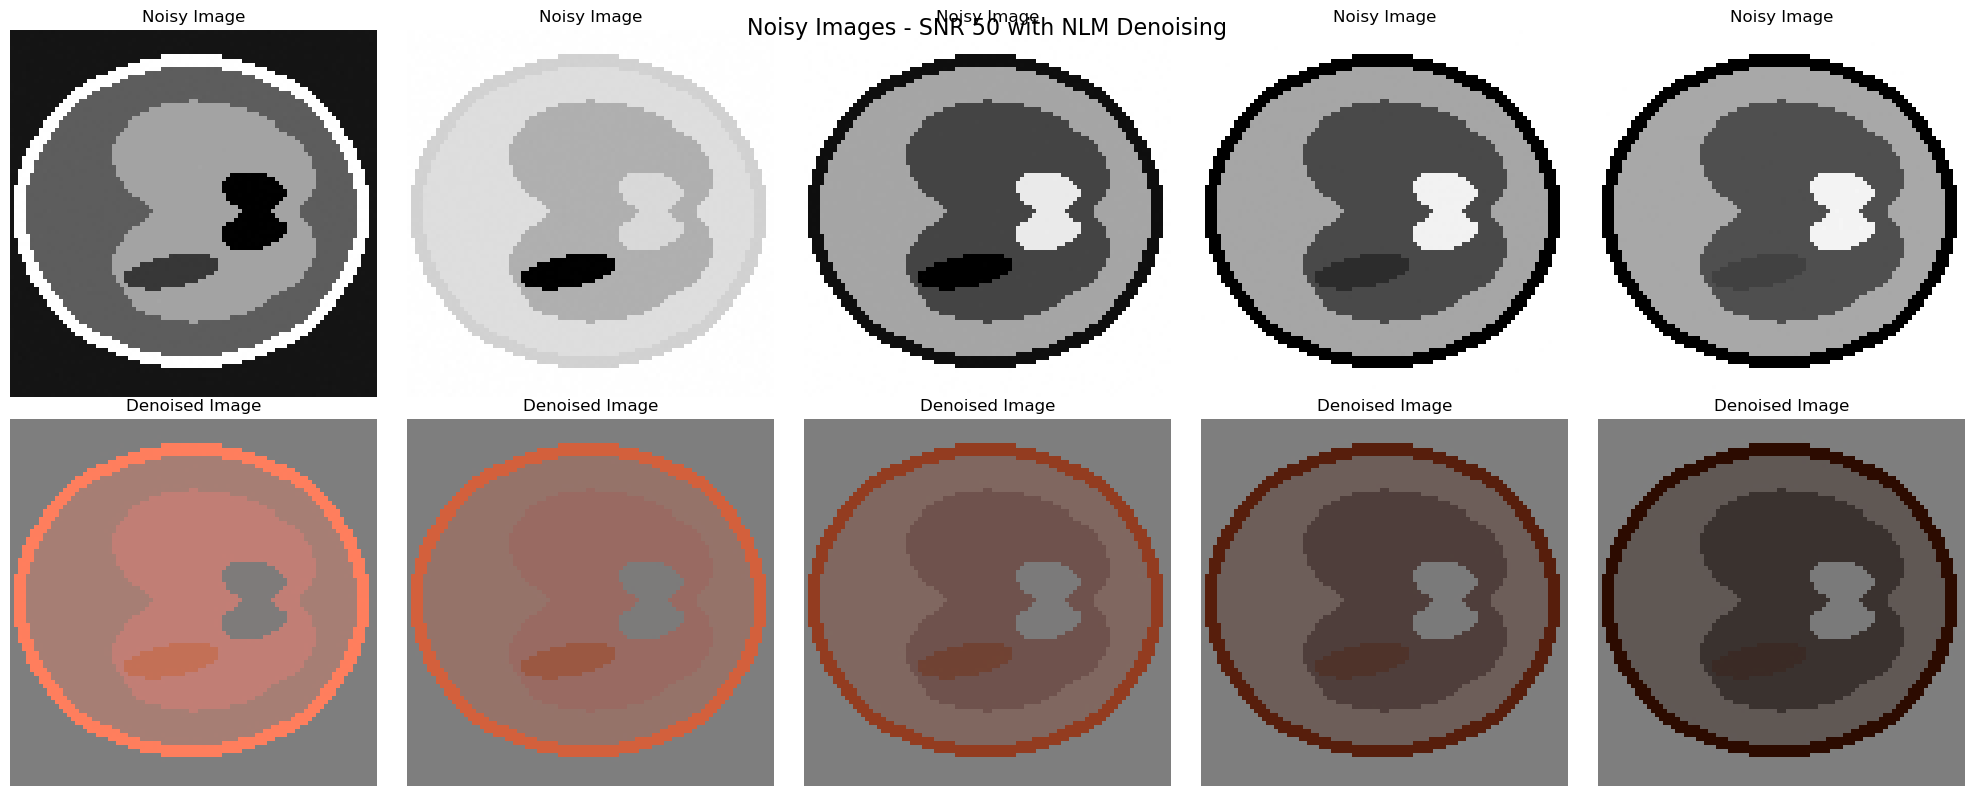